In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
os.environ['KERAS_BACKEND'] = "tensorflow"
#TensorFlow: Channels last order.
#Theano: Channels first order.
#CNTK: Channels last order.

In [2]:
import matplotlib
#from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as im
import random
from tqdm import tqdm
from keras import models #vamos precisar desta biblioteca para aceder às camadas do modelo
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint
from keras import backend as K
#K.set_image_dim_ordering('tf') 
K.image_data_format() == 'channels_last'
from keras.utils import np_utils

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Carregar e visualizar os dados e fazer as devidas transformações.

In [3]:
PATHTRAIN='./CINIC-10/train'
PATHTEST='./CINIC-10/test'

CATEGORIES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def show_data(path_set):
    for category in CATEGORIES:
        path = os.path.join(path_set,category)  # create path
        for img in os.listdir(path):  # iterate over each image
            img_array = cv2.imread(os.path.join(path,img))  # convert to array
            plt.imshow(img_array)  # graph it
            plt.show()  # display!

            break
        break
    return img_array

IMG_SIZE = 32

def show_resize_data(img_array):
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(new_array)
    plt.show()

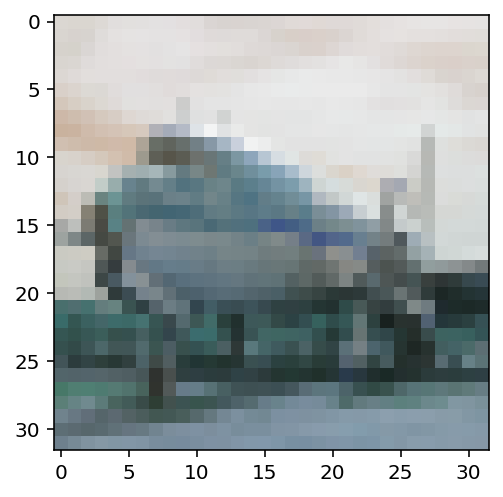

In [4]:
show_data_train = show_data(PATHTRAIN)

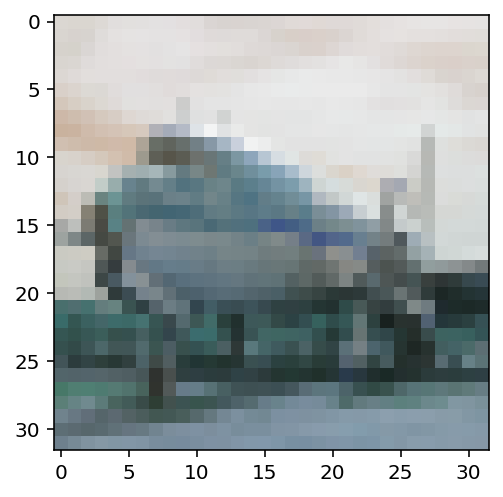

In [5]:
show_resize_data(show_data_train)

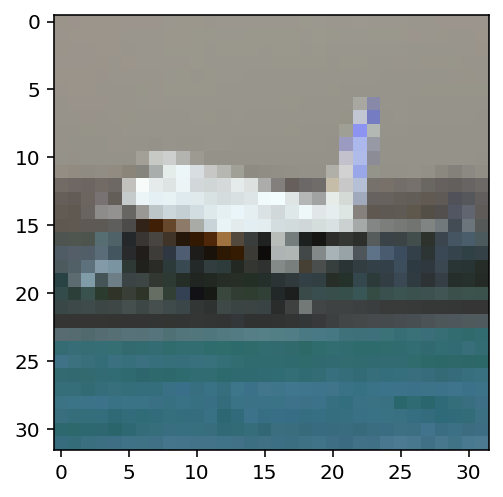

In [6]:
show_data_test = show_data(PATHTEST)

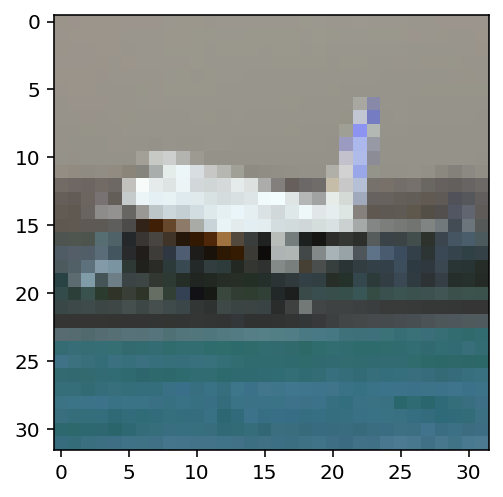

In [7]:
show_resize_data(show_data_test)

In [8]:
def create_set_data(path_set):
    data = []
    for category in CATEGORIES:

        path = os.path.join(path_set,category)  # create path 
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img) )  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
    return data

In [9]:
PATHTRAIN='./CINIC-10/train'
PATHTESTE='./CINIC-10/test'

training_data = create_set_data(PATHTRAIN)
test_data = create_set_data(PATHTEST)

100%|██████████| 9000/9000 [00:13<00:00, 683.62it/s]


In [10]:
random.shuffle(training_data)

for sample in training_data[:10]:
    print(sample[1])

7
0
1
0
5
7
6
0
3
2


In [11]:
X_train = []
y_train = []

for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

print(X_train[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))

X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

[[[[ 66  57  53]
   [ 67  57  52]
   [103 100  97]
   ...
   [ 63  50  47]
   [ 53  44  41]
   [ 55  46  43]]

  [[ 59  54  49]
   [ 83  85  79]
   [ 89 104  98]
   ...
   [ 55  42  38]
   [ 56  47  44]
   [ 64  55  52]]

  [[ 63  63  59]
   [ 89 104  97]
   [ 88 109 102]
   ...
   [ 53  42  38]
   [ 56  48  44]
   [ 51  43  40]]

  ...

  [[111 133 123]
   [109 126 117]
   [105 119 111]
   ...
   [104 101  91]
   [106 102  93]
   [104 100  91]]

  [[106 115 107]
   [119 122 116]
   [116 126 118]
   ...
   [101 100  93]
   [100 103  96]
   [ 98 101  94]]

  [[101  96  87]
   [106 101  92]
   [103  99  86]
   ...
   [103 105  99]
   [ 98  98  87]
   [ 99 103  98]]]]


In [12]:
random.shuffle(test_data)

for sample in test_data[:10]:
    print(sample[1])

1
4
9
1
3
8
8
3
6
5


In [13]:
X_test = []
y_test = []

for features,label in test_data:
    X_test.append(features)
    y_test.append(label)

print(X_test[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

[[[[ 37  43  39]
   [ 50  63  69]
   [ 56  63  60]
   ...
   [115 111  96]
   [101  97  80]
   [ 86  83  65]]

  [[ 23  33  30]
   [ 48  53  40]
   [ 70  75  73]
   ...
   [ 58  59  45]
   [ 41  42  28]
   [ 53  55  40]]

  [[ 36  47  51]
   [ 48  51  34]
   [ 68  72  68]
   ...
   [ 70  70  55]
   [ 51  52  36]
   [ 66  66  50]]

  ...

  [[152 143 125]
   [149 140 125]
   [155 144 125]
   ...
   [156 149 133]
   [151 142 124]
   [151 142 124]]

  [[146 138 120]
   [150 140 120]
   [153 144 127]
   ...
   [150 141 123]
   [154 147 132]
   [143 134 116]]

  [[147 140 123]
   [151 141 124]
   [151 143 127]
   ...
   [155 148 135]
   [155 144 126]
   [146 139 123]]]]


In [14]:
X_train = X_train/255.0
X_test = X_test/255.0

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [15]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

O formato da imagem fica 32 pixels por 32 pixels com três canais.

Construir uma rede CNN mais complexa do que a do TP1:

In [16]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dense(10, activation='softmax'))

In [17]:
def print_model(model, fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

Visualisar a arquitetura do modelo:

In [18]:
#print_model(model, "model_cinic10_cnn_plus.png")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)         

Compilar o modelo utilizando adam como otimizador, categorical_crossentropy para função de loss e accuracy como metrica de avaliação:

In [19]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss = 'categorical_crossentropy',optimizer = 'rmsprop', metrics = ['accuracy'])

#lrate = 0.0001
#decay = lrate/no_of_epochs
#sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
#model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

O modelo vai treinar durante 15 epochs mas vamos utilizar ModelCheckpoint para guardar os pesos da melhor epoch. val_accuracy será utilizada como métrica para definir o melhor modelo.

In [20]:
checkpointer = ModelCheckpoint(filepath="best_weights_cinic_plus.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True)

Treino do modelo, onde se inclui o callback para o checkpointer.

In [21]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=15,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpointer])


Train on 90000 samples, validate on 90000 samples
Epoch 1/15
90000/90000 [==============================] - 1044s 12ms/step - loss: 1.6460 - accuracy: 0.3907 - val_loss: 1.7202 - val_accuracy: 0.3692

Epoch 00001: val_accuracy improved from -inf to 0.36917, saving model to best_weights_cinic_plus.hdf5
Epoch 2/15
90000/90000 [==============================] - 898s 10ms/step - loss: 1.3495 - accuracy: 0.5070 - val_loss: 1.3275 - val_accuracy: 0.5187

Epoch 00002: val_accuracy improved from 0.36917 to 0.51874, saving model to best_weights_cinic_plus.hdf5
Epoch 3/15
90000/90000 [==============================] - 906s 10ms/step - loss: 1.2191 - accuracy: 0.5602 - val_loss: 1.2335 - val_accuracy: 0.5526

Epoch 00003: val_accuracy improved from 0.51874 to 0.55256, saving model to best_weights_cinic_plus.hdf5
Epoch 4/15
90000/90000 [==============================] - 947s 11ms/step - loss: 1.1314 - accuracy: 0.5954 - val_loss: 1.1520 - val_accuracy: 0.5905

Epoch 00004: val_accuracy improved f

Gravar o melhor modelo (rede e pesos) para utilizar posteriormente:

In [22]:
#model.save('cinic10_cnn_simples.h5')
model.save('cinic10_cnn_plus.h5')

#para utilizar:
#model=load_model('cinic10_cnn_simples.h5')

Visualizar o comportamento da rede durante o periodo de treino:

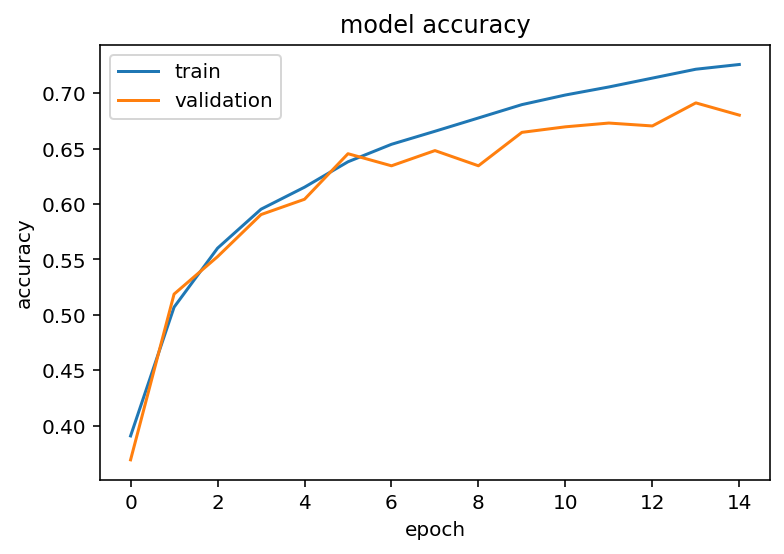

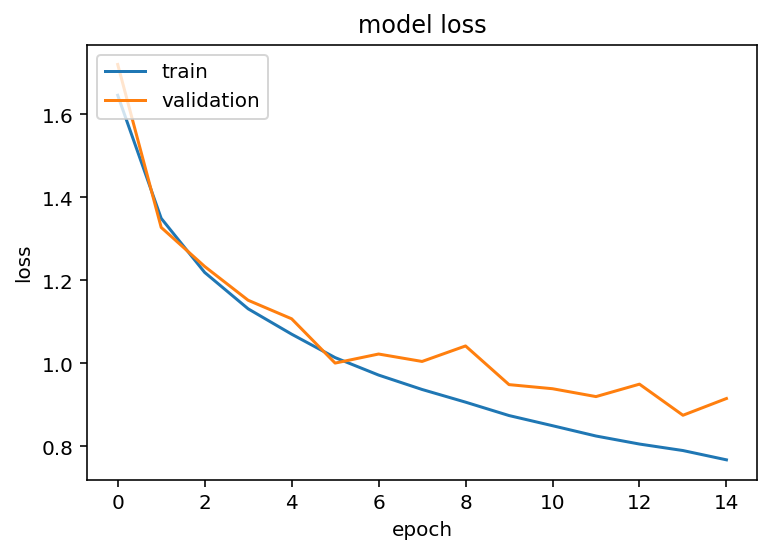

In [23]:
#funções para visulização do historial de aprendizagem
def print_history_accuracy(history):
    #print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def print_history_loss(history):
    #print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

print_history_accuracy(history)
print_history_loss(history)

Pode-se verificar que depois da epoch 13 o modelo começa a entrar em overfitting, no entanto guardamos os pesos da melhor epoch.

Só para confirmação podemos carregar algumas imagens e verificar a correspondente previsão:

X_test: (90000, 32, 32, 3)
y_test: (90000, 10)
Imagem: (32, 32, 3)


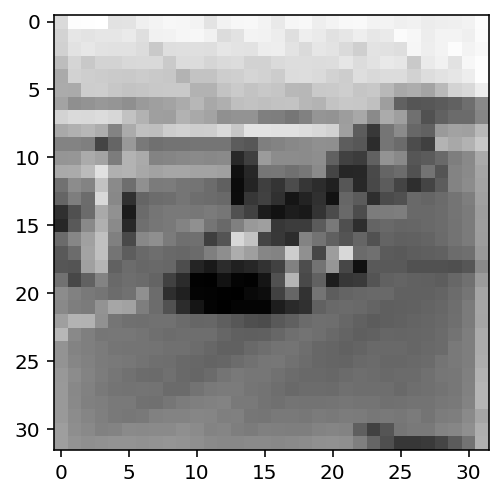

label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
antes do aumento de mais uma dimensão: (32, 32, 3)
depois do aumento de mais uma dimensão: (1, 32, 32, 3)
previsão: [[3.95305395e-01 1.14635296e-01 4.18006582e-03 5.76821528e-03
  2.34037191e-02 8.81233346e-03 3.18237901e-04 2.20630243e-02
  1.80590585e-01 2.44923159e-01]]
Classe prevista: [0]


In [24]:
# Visualizar imagem, label e correspondente previsão
def visualize_previsao(x_test, y_test, img_a_mostrar):
    print("X_test:",x_test.shape)
    print("y_test:",y_test.shape)
    print("Imagem:",x_test[img_a_mostrar].shape)
    plt.imshow(x_test[img_a_mostrar,:,:,0], cmap='gray')
    plt.show()
    print("label:",y_test[img_a_mostrar])
    print("antes do aumento de mais uma dimensão:",x_test[img_a_mostrar].shape)
    imagem_tensor = np.expand_dims(x_test[img_a_mostrar], axis=0)
    print("depois do aumento de mais uma dimensão:",imagem_tensor.shape)
    print("previsão:",model.predict(imagem_tensor))
    classes = model.predict_classes(imagem_tensor)
    print('Classe prevista:',classes)
    return imagem_tensor


imagem_tensor = visualize_previsao(X_test, y_test, 3)

As previsões estão incorretas, mas existe alguma ligação nos detalhes.

Vamos agora visualizar as ativações intermédias.

Instanciação de um modelo a partir de um tensor de input e uma lista de tensores de output:

In [25]:
#Vamos buscar os outputs das primeiras 5 (simples) camadas da rede ou 12 para a plus
camadas_outputs = []
for layer in model.layers[:12]:
    print(layer.output.shape)
    camadas_outputs.append(layer.output)

# e depois criamos um modelo que retorna estes outputs dado os inputs do modelo
activation_model = models.Model(inputs=model.input, outputs=camadas_outputs) 

(?, 32, 32, 32)
(?, 32, 32, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 64)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 4, 4, 64)


Dado o input de uma imagem, este modelo retorna os valores das camadas de ativação no modelo original.
Executar o modelo em modo de previsão:

In [26]:
activations = activation_model.predict(imagem_tensor) 
# Retorna uma lista com dois Numpy arrays: um array por camada de ativação

Por exemplo, esta é a ativação da primeira camada convolucional da imagem de input:

In [27]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 32, 32, 32)


Trata-se de um feature map de 32 × 32 com 32 FeatureMaps. Vamos visualizar o 10º FeatureMap de ativação da ativação da primeira camada do modelo original.

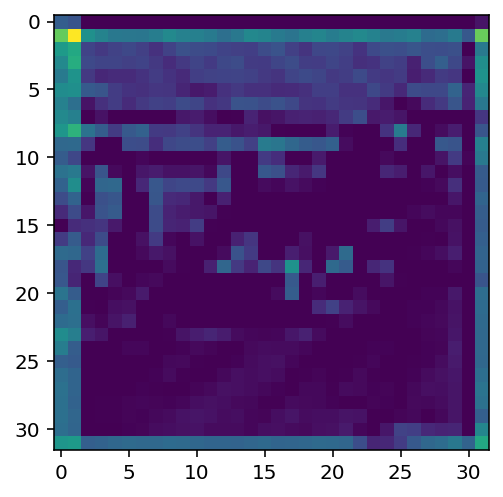

In [28]:
plt.imshow(first_layer_activation[0, :, :, 9], cmap='viridis')
plt.show()

Para melhor compreensão, vamos visualizar todas as ativações em todas as camadas:

nome_camada: conv2d_1
n_features: 32
size: 32
n_linhas: 2
nome_camada: conv2d_2
n_features: 32
size: 32
n_linhas: 2
nome_camada: max_pooling2d_1
n_features: 32
size: 16
n_linhas: 2
nome_camada: batch_normalization_1
n_features: 32
size: 16
n_linhas: 2


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


nome_camada: conv2d_3
n_features: 64
size: 16
n_linhas: 4
nome_camada: conv2d_4
n_features: 64
size: 16
n_linhas: 4
nome_camada: max_pooling2d_2
n_features: 64
size: 8
n_linhas: 4
nome_camada: batch_normalization_2
n_features: 64
size: 8
n_linhas: 4
nome_camada: dropout_1
n_features: 64
size: 8
n_linhas: 4
nome_camada: conv2d_5
n_features: 64
size: 8
n_linhas: 4
nome_camada: conv2d_6
n_features: 64
size: 8
n_linhas: 4
nome_camada: max_pooling2d_3
n_features: 64
size: 4
n_linhas: 4


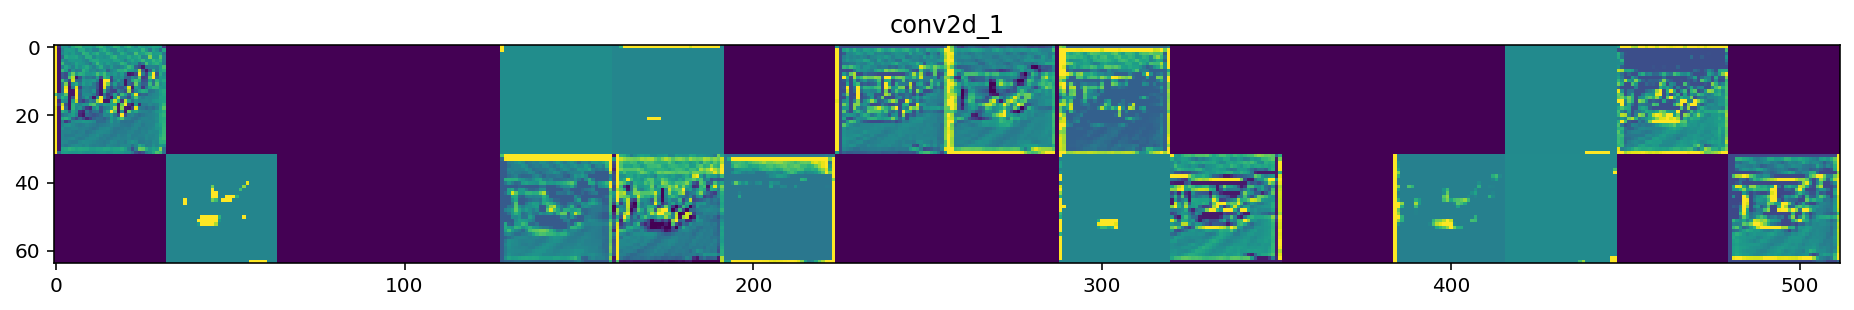

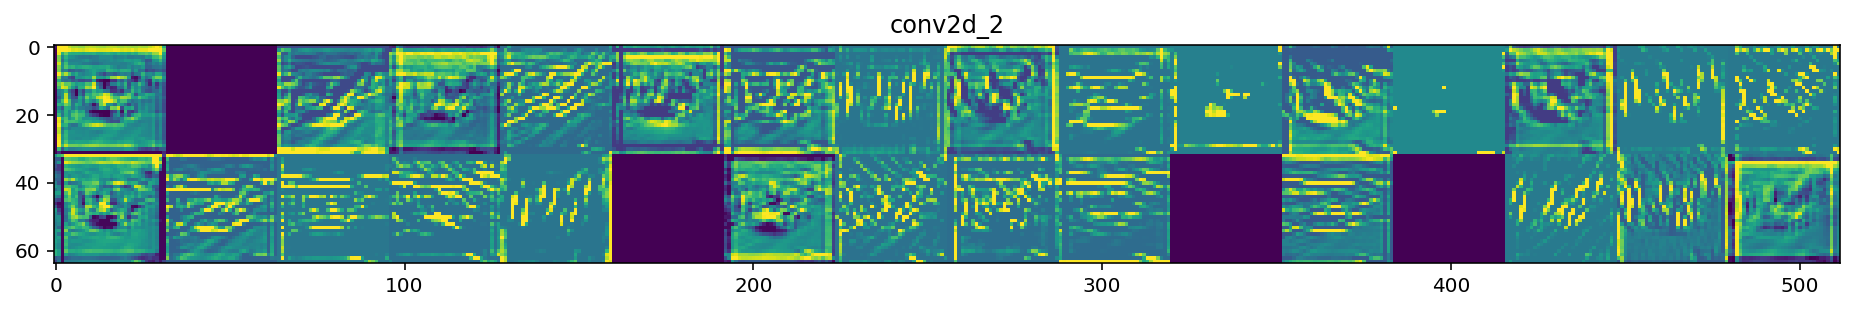

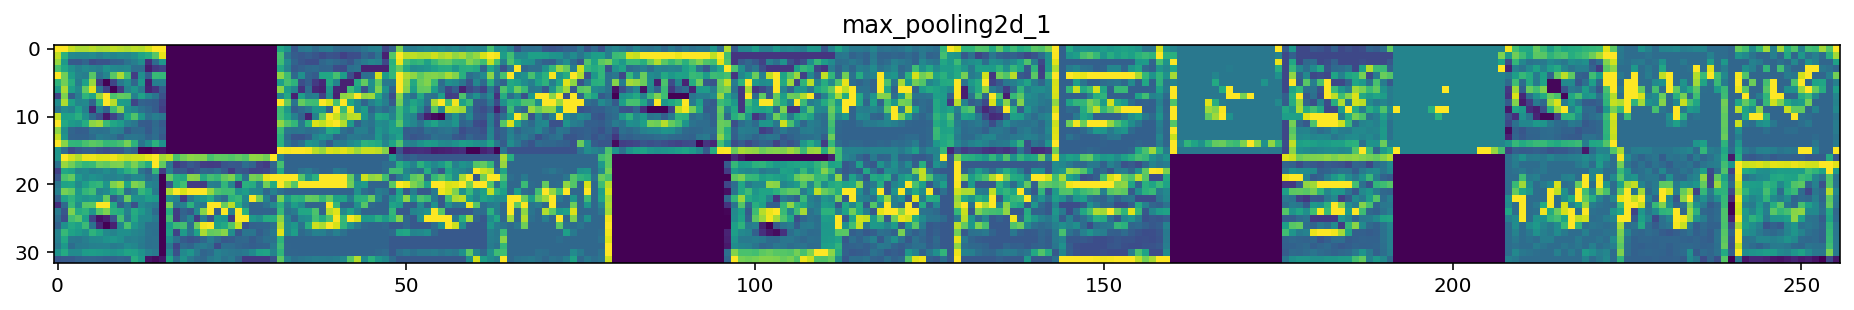

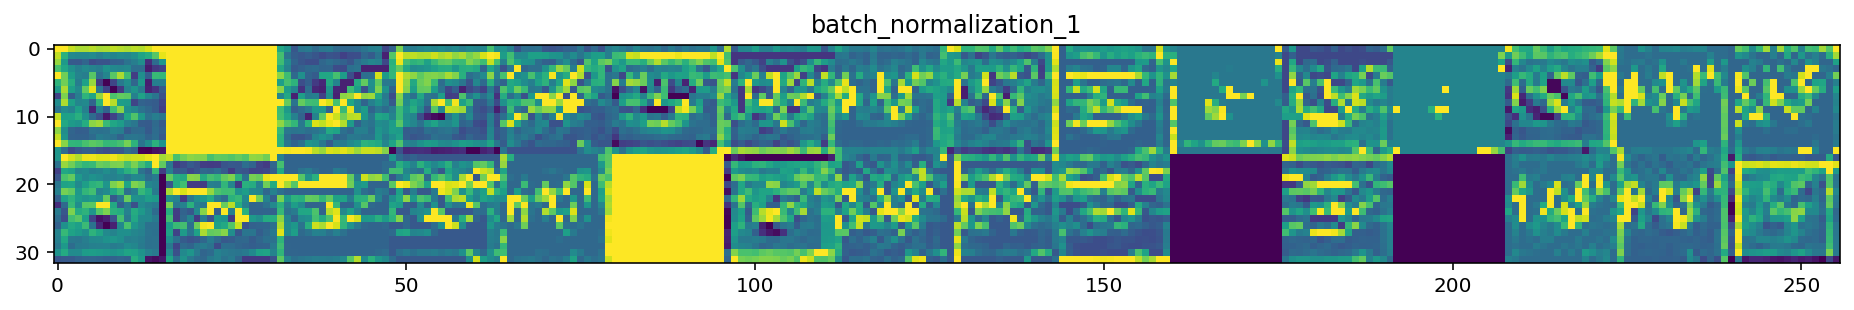

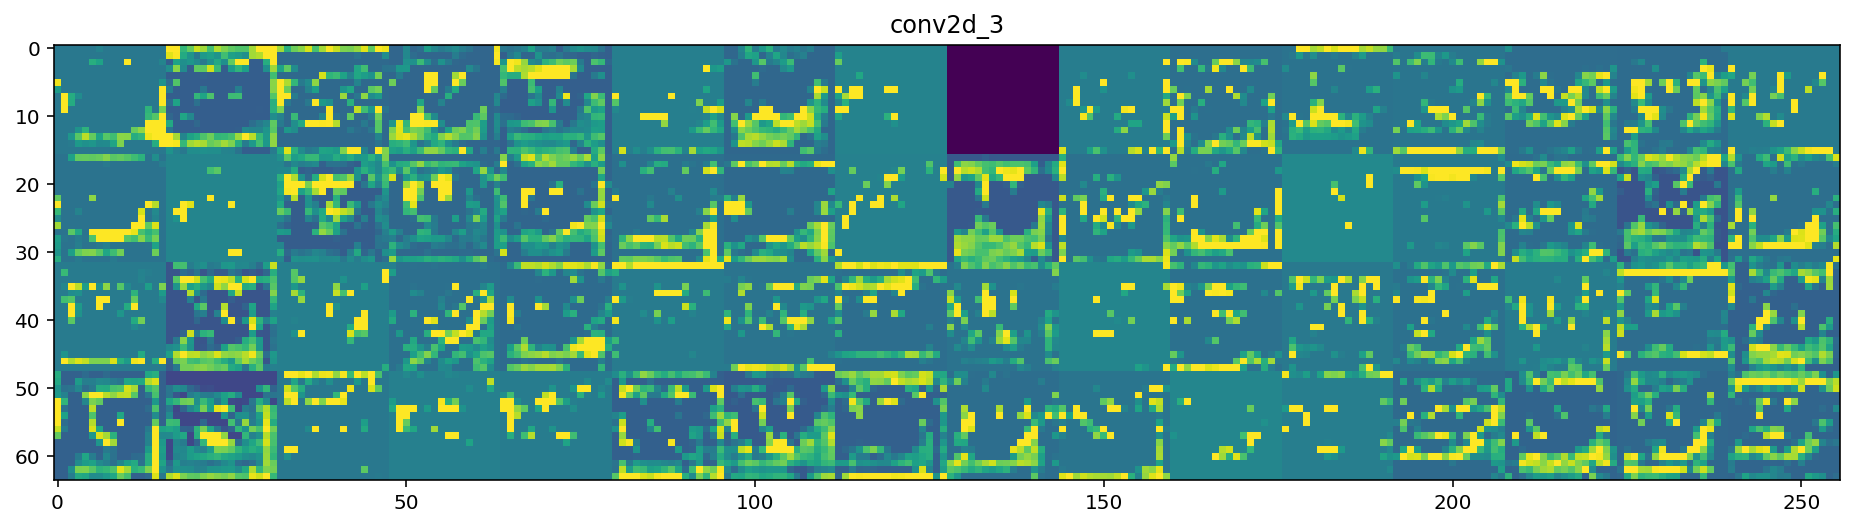

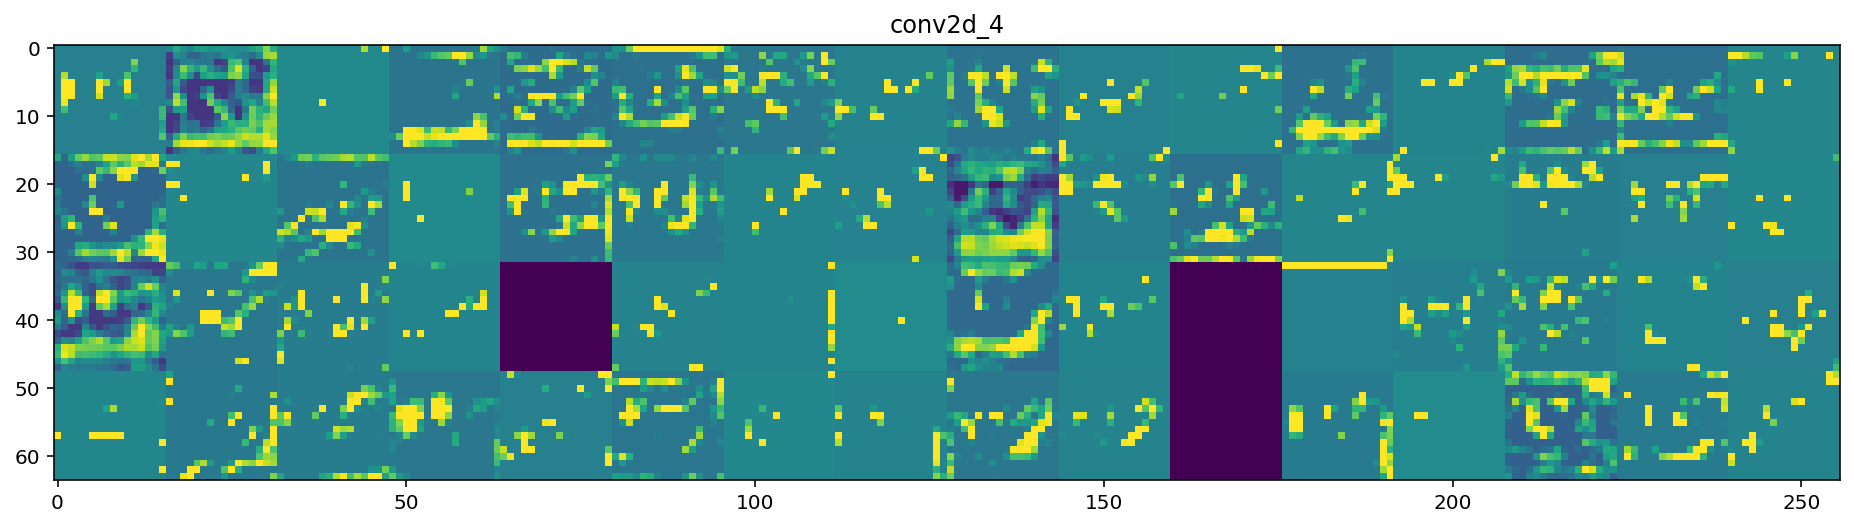

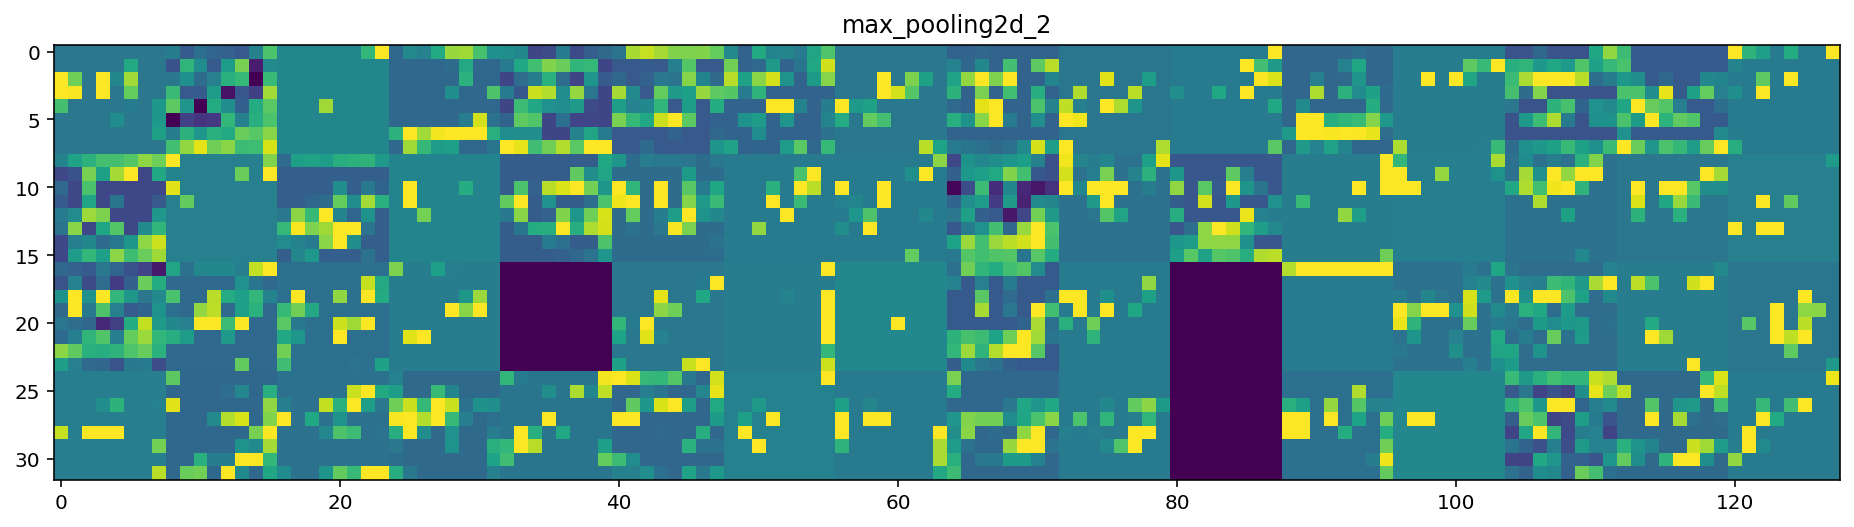

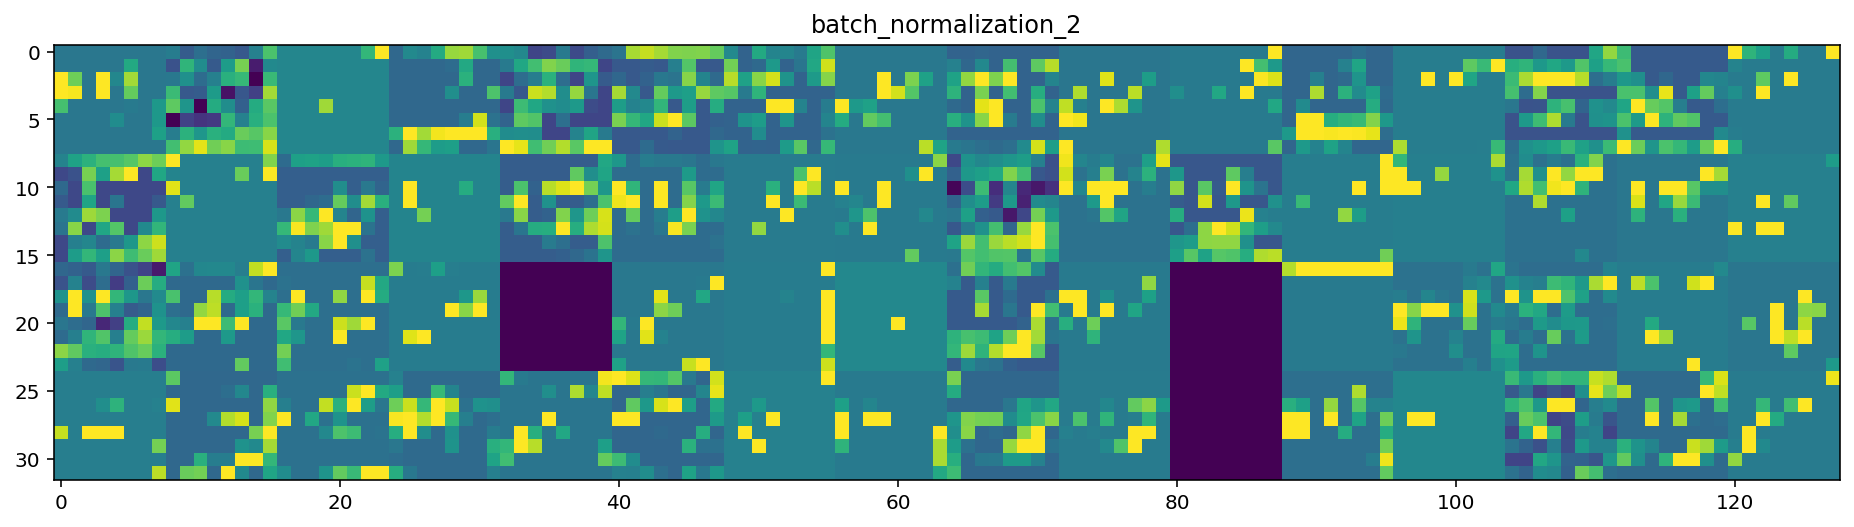

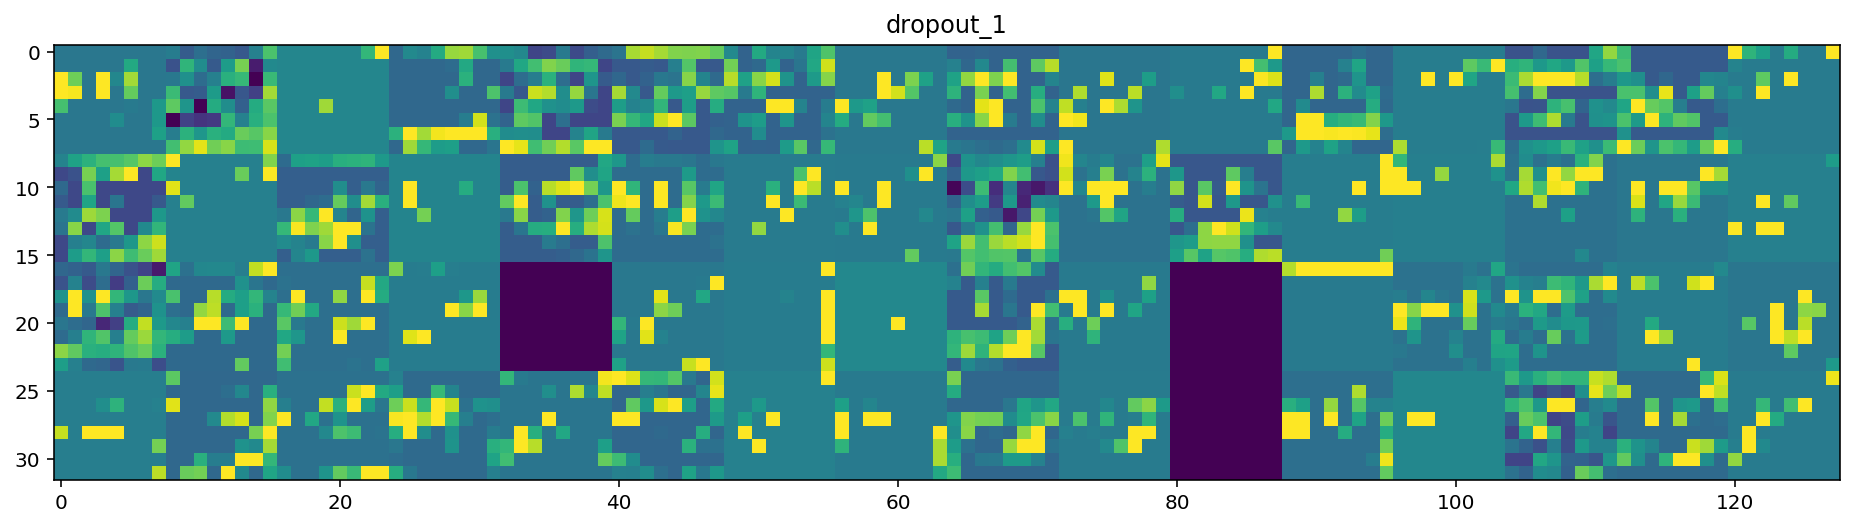

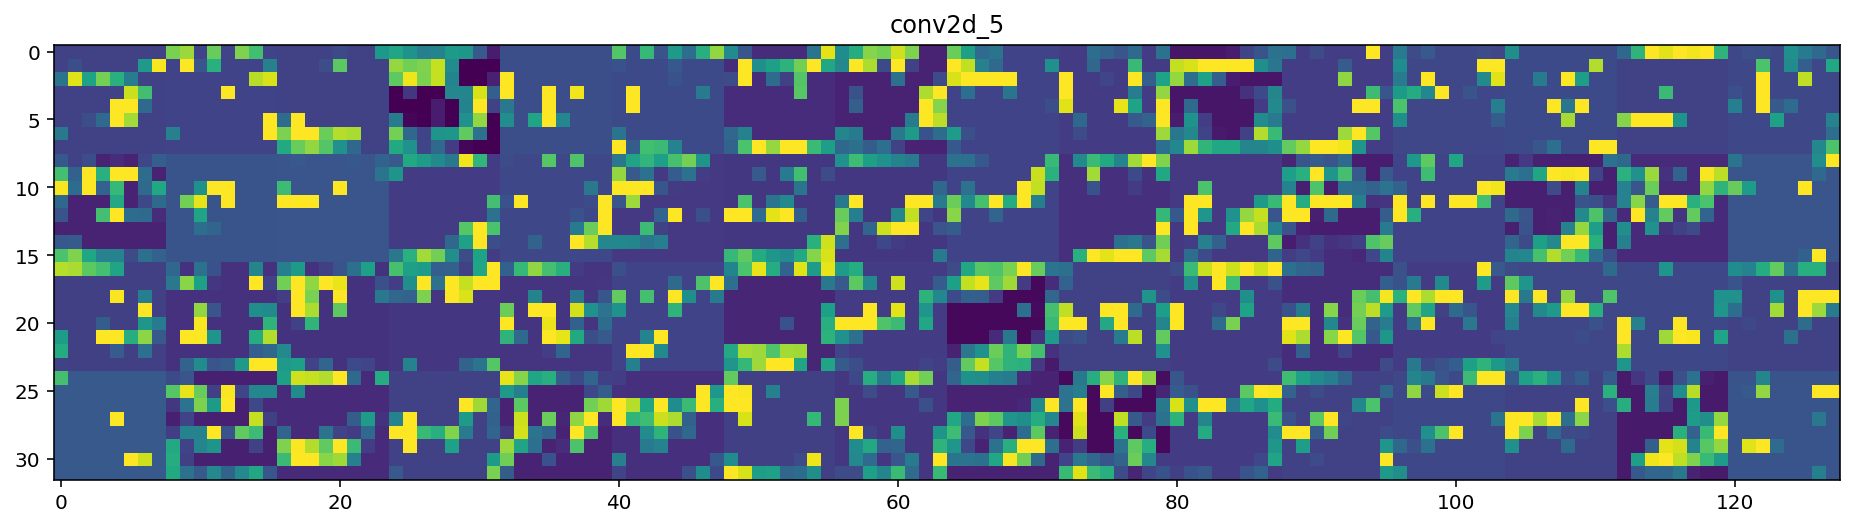

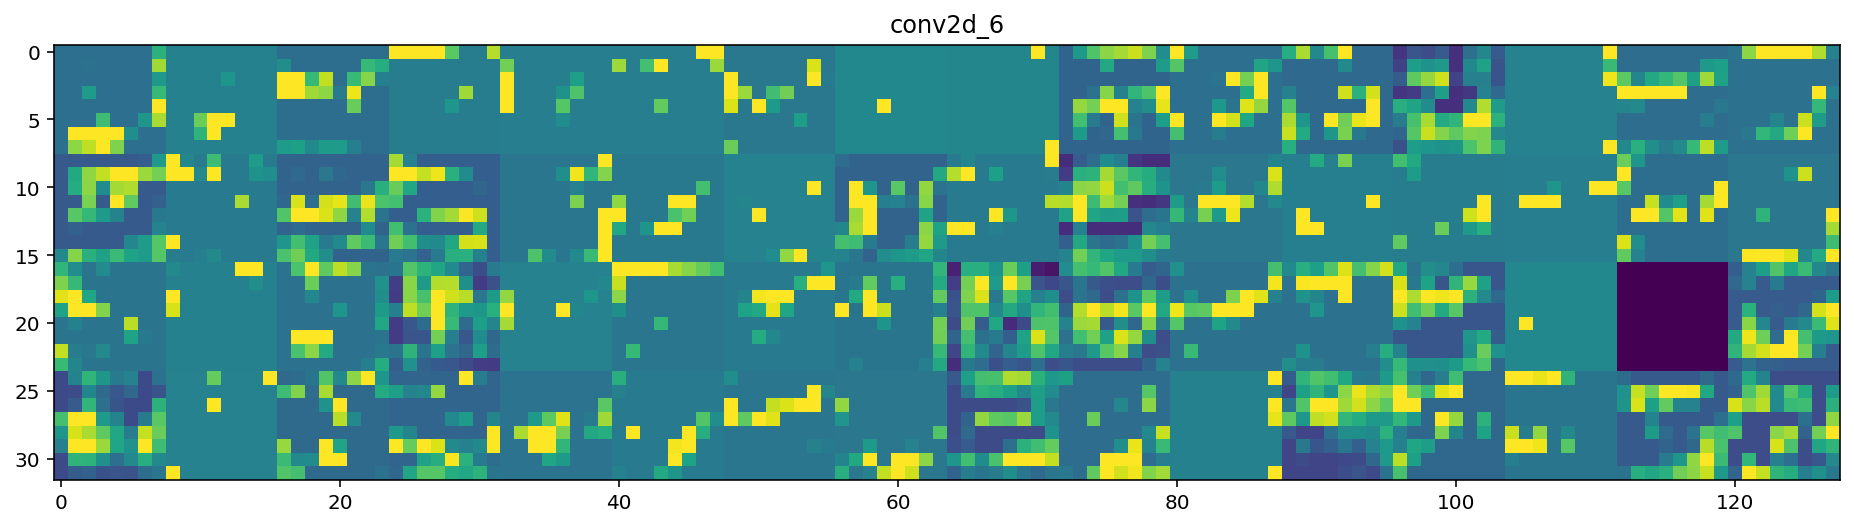

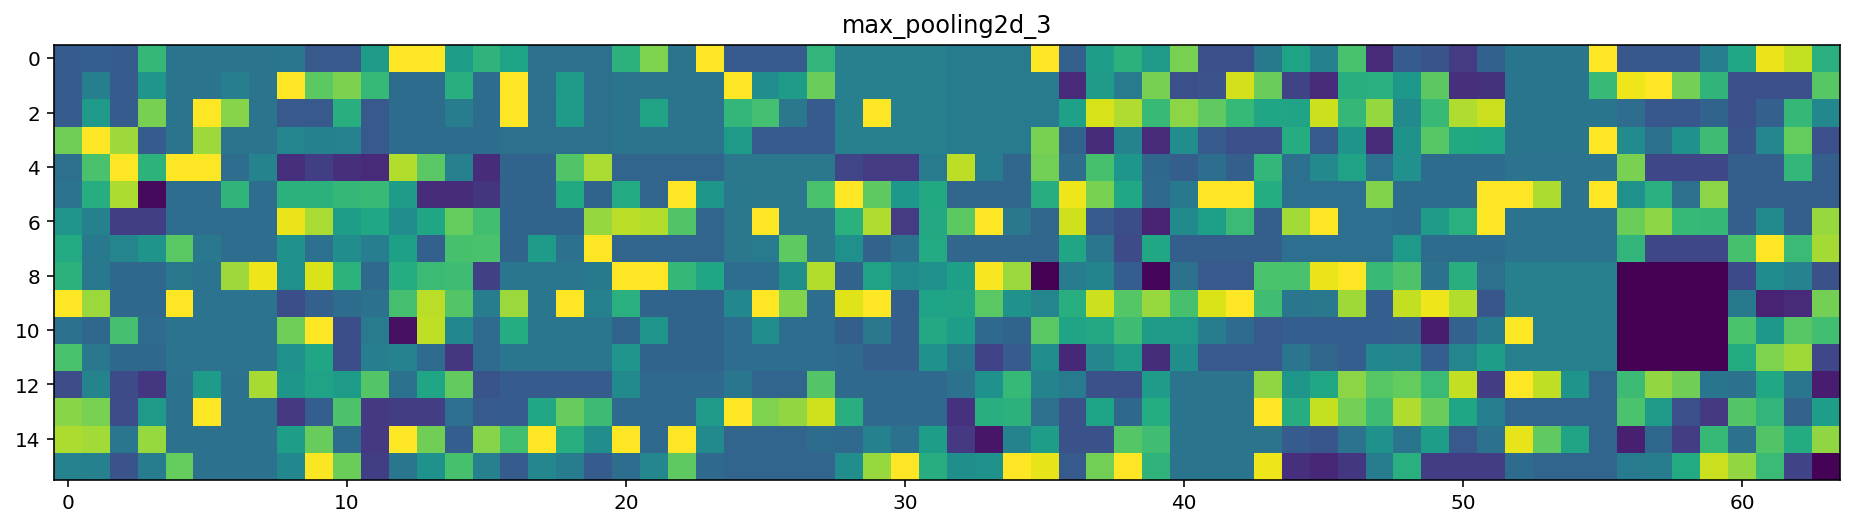

In [29]:
nomes_camadas = []
for camada in model.layers[:12]:
    nomes_camadas.append(camada.name) # para puder colocar o nome da cada camada nas visualizações
    
imagens_por_linha = int(first_layer_activation.shape[3] / 2)

for nome_camada, ativacao_camada in zip(nomes_camadas, activations): # o zip permite iterar simultaneamente em 2 listas
    n_features = ativacao_camada.shape[-1] # Numero de features no feature map, pois é o que está na ultima dimensão
    size = ativacao_camada.shape[1] #O feature map tem shape (1, tamanho, tamanho, numero_features).
    n_linhas = -(-n_features // imagens_por_linha) # Empilha os canais de ativação nesta matriz
    print("nome_camada:",nome_camada)
    print("n_features:",n_features)
    print("size:",size)
    print("n_linhas:",n_linhas)
    display_grid = np.zeros((size * n_linhas, imagens_por_linha * size))
    for col in range(n_linhas): # para fazer o display com 15 imagens por linha
        for lin in range(imagens_por_linha):
            #verificar aqui se a imagem existe
            imagem = ativacao_camada[0,:,:,col * imagens_por_linha + lin] #isto pode dar erro de out-of-range
            imagem -= imagem.mean() # pos-processamento para melhor visualização
            imagem /= imagem.std()
            imagem *= 64
            imagem += 128
            imagem = np.clip(imagem, 0, 255).astype('uint8') #valores <0 ficam 0 e >255 ficam = 255
            display_grid[col * size : (col + 1) * size,lin * size : (lin + 1) * size] = imagem
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(nome_camada)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')            
